# Comparison of Machine Learning Models for Sentiment Analysis
- Random Forest
- Support Vector Classification (SVC)
- Multinomial Naive Bayes
- Logistic Regression

In [2]:
# import dependencies
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

In [3]:
# load data
conn = sqlite3.connect('/resources/ukraine_analysis.sqlite')
tweet_sentiments_df = pd.read_sql('select * from tweets', conn)
tweet_sentiments_df.head()

,tweetcreatedts,text,hashtags,retweetcount,favorite_count,country,neg,neu,pos,compound,sentiment
0,03/08,a fox s tale for,"[{'text': 'Ukraine', 'indices': [19, 27]}]",0.0,0.0,uk,0.00,1.000,0.000,0.0000,neutral
1,03/08,ukraine,"[{'text': 'Ukraine', 'indices': [11, 19]}, {'t...",0.0,0.0,france,0.00,1.000,0.000,0.0000,neutral
2,03/08,russia s enlargement redlines cable from...,"[{'text': 'NATO', 'indices': [25, 30]}, {'text...",1377.0,0.0,france,0.00,1.000,0.000,0.0000,neutral
3,03/08,can t help but think that hm queen is quietly ...,"[{'text': 'Ukraine️', 'indices': [89, 98]}]",34.0,0.0,australia,0.00,0.875,0.125,0.2144,neutral
4,03/08,another invading general killed by freedom f...,"[{'text': 'Russian', 'indices': [36, 44]}, {'t...",2.0,0.0,france,0.41,0.288,0.302,-0.1280,neutral


In [4]:
# check the count of the sent_score where Negative, Positive, Neutral
tweet_sentiments_df["sentiment"].value_counts()

negative    770310
neutral     746785
positive    586597
Name: sentiment, dtype: int64

In [5]:
# Dropping all neutral sentiments to generalize the model
tweet_sentiments_df = tweet_sentiments_df[tweet_sentiments_df["sentiment"]!="neutral"]

In [6]:
# Creating encoded column for sentiments by using .factorize() function in pandas encode the object as an 
#enumerated type or categorical variable. 
tweet_sentiments_df["sent_score"] = tweet_sentiments_df["sentiment"].factorize()[0]
tweet_sentiments_df.head()

,tweetcreatedts,text,hashtags,retweetcount,favorite_count,country,neg,neu,pos,compound,sentiment,sent_score
5,03/08,appointing me as your ghostwriter will give yo...,"[{'text': 'Ukraine️', 'indices': [184, 193]}, ...",0.0,0.0,nigeria,0.000,0.696,0.304,0.8360,positive,0
6,03/08,thugs for hire from s murderous wagner ...,"[{'text': 'Putin', 'indices': [49, 55]}]",12.0,0.0,uk,0.259,0.741,0.000,-0.6369,negative,1
8,03/08,a heartfelt message from in kiev on march th...,"[{'text': 'ukrainevoicenotes', 'indices': [76,...",118.0,0.0,usa,0.000,0.696,0.304,0.5423,positive,0
11,03/08,kiril was months old he died because of bo...,"[{'text': 'Russian', 'indices': [63, 71]}, {'t...",22.0,0.0,greece,0.286,0.714,0.000,-0.5574,negative,1
12,03/08,an international terrorist with a massive nucl...,"[{'text': 'StopPutin', 'indices': [129, 139]}]",18.0,0.0,syria,0.108,0.686,0.206,0.5106,positive,0


In [7]:
# get random sample 
sample_df = tweet_sentiments_df.groupby('sent_score').sample(frac=.01)
sample_df.shape

(13569, 12)

In [8]:
# Standardize sentiment score distribution
sample_df["sent_score"].value_counts(normalize=True)

1    0.567691
0    0.432309
Name: sent_score, dtype: float64

In [9]:
# define independent and dependent variables
X=sample_df['text']
y=sample_df['sent_score']

In [10]:
# split the data into train and test
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=.8, random_state=42)

## TF-IDF (Term Frequency-Inverse Document Frequency)
It measures how many times a term exists in a document and gives less weight to most frequent terms, as those terms will probably be unhelpful in categorizing the dataset.

In [11]:
# Instantiate and fit TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=3,sublinear_tf=True,encoding="latin-1", ngram_range=(1,2),
                             stop_words='english')

In [12]:
# Transform text into numeric vectors
X_train_tf= vectorizer.fit_transform(X_train.reset_index()["text"]).toarray()
X_test_tf = vectorizer.transform(X_test.reset_index()["text"]).toarray()

In [13]:
X_train_tf.shape

(10855, 13745)

## Compare Models

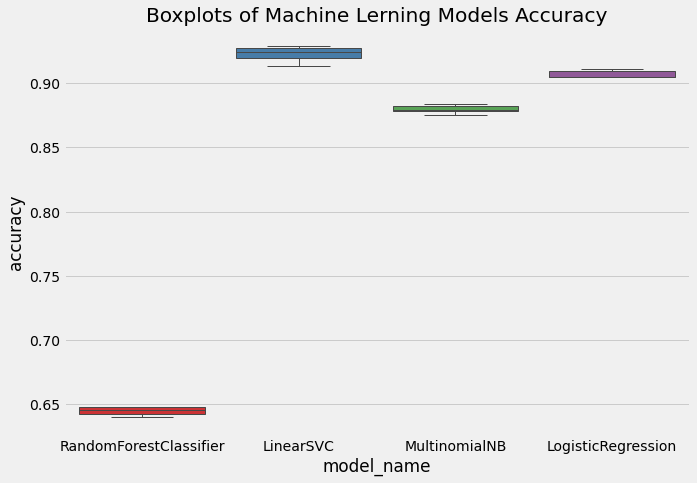

In [14]:
# run data over various models
models = [
    RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# plot boxplots of models accuracy
plt.subplots(figsize = (10,7))
plt.title('Boxplots of Machine Lerning Models Accuracy')
sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette="Set1", linewidth=1)

plt.show()

# From: https://github.com/HudaKas/Twitter-Sentiment-Analysis/blob/main/tweet%20analaysis.ipynb
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [15]:
# check the mean of the accuracy for each model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.922524
LogisticRegression        0.907047
MultinomialNB             0.879687
RandomForestClassifier    0.644680
Name: accuracy, dtype: float64

## Implement Linear SVC

In [16]:
# define and fit Linear SVC model
model = LinearSVC()
model.fit(X_train_tf, y_train)

LinearSVC()

In [17]:
# predict outcome using model
y_pred = model.predict(X_test_tf)
predictions = pd.DataFrame({
   "Prediction": y_pred,
   "Actual": y_test
}).reset_index(drop=True)
predictions.head()

,Prediction,Actual
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


In [18]:
# evaluate model
accuracy_score(y_test, y_pred)

0.9196757553426677

In [26]:
# print confusion matrix and classification report
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1170
           1       0.92      0.94      0.93      1544

    accuracy                           0.92      2714
   macro avg       0.92      0.92      0.92      2714
weighted avg       0.92      0.92      0.92      2714



In [39]:
import dataframe_image as dfi
report_dict = {'positive': {'precision': 0.92,
  'recall': 0.89,
  'f1-score': 0.91,
  'support': '1170'},
 'negative': {'precision': 0.92,
  'recall': 0.94,
  'f1-score': 0.93,
  'support': '1544'},
 'accuracy': {'precision': ' ',
  'recall': ' ',
  'f1-score': 0.92,
  'support': '2714'},
 'macro avg': {'precision': 0.92,
  'recall': 0.92,
  'f1-score': 0.92,
  'support': '2714'},
 'weighted avg': {'precision': 0.92,
  'recall': 0.92,
  'f1-score': 0.92,
  'support': '2714'}}


# report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# save classification report as image
dfi.export(df,"classification_report.png")

[0403/163914.951891:INFO:headless_shell.cc(659)] Written to file /var/folders/xl/8gktbknx7195tnyfgqw7swqw0000gn/T/tmp2zhepre0/temp.png.


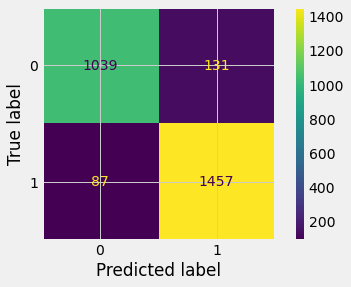

In [38]:
# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Feaure Importance
from: https://github.com/HudaKas/Twitter-Sentiment-Analysis/blob/main/tweet%20analaysis.ipynb

In [40]:
# Referred the below link to plot Most important features(words) within the model
#https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d#:~:text=Once%20a%20linear%20SVM%20is,can%20be%20accessed%20with%20svm.&text=The%20absolute%20size%20of%20the,for%20the%20data%20separation%20task.

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

/Users/floramatos/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


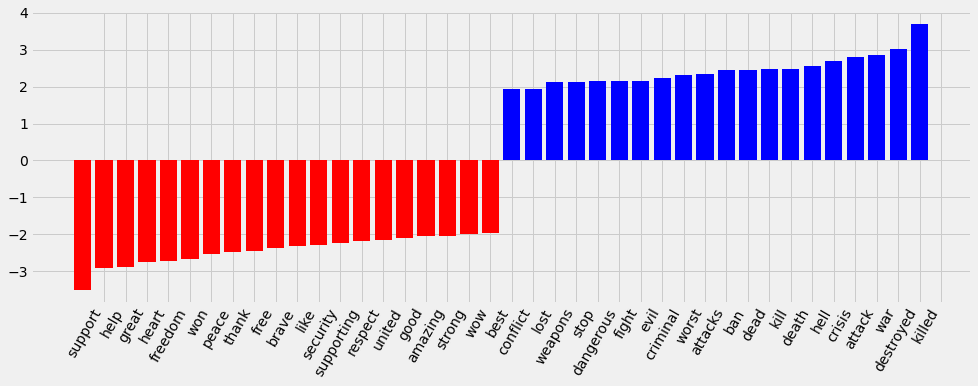

In [41]:
feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
df_feat=pd.DataFrame(coefs_with_fns)
df_feat.columns='coefficient','word'
df_feat.sort_values(by='coefficient')
plot_coefficients(model, feature_names)

In [42]:
# close connection with sqlite
conn.close()